# Experimenting with new device

- this playbook contains the code for the experimentation with new device

In [8]:
import os
import csv
import pandas as pd

version = "v6"
dataset_path = f"../data/processed/"

# files
filename_s = f"{version}-2_stages-full_statistical.csv"
filename_s_n = f"{version}-2_stages-full_statistical_normalized.csv"
filename_s_s = f"{version}-2_stages-full_statistical_standardized.csv"
filename_f = f"{version}-2_stages-fourier_int_XYZ.csv"
filename_f_n = f"{version}-2_stages-fourier_normalized_int_XYZ.csv"
filename_f_s = f"{version}-2_stages-fourier_standardized_XYZ.csv"


# datasets
df_statistical = pd.read_csv(f"{dataset_path}/{filename_s}")
df_statistical_normalized = pd.read_csv(f"{dataset_path}/{filename_s_n}")
df_statistical_standardized = pd.read_csv(f"{dataset_path}/{filename_s_s}")
df_spectral = pd.read_csv(f"{dataset_path}/{filename_f}")
df_spectral_normalized = pd.read_csv(f"{dataset_path}/{filename_f_n}")
df_spectral_standardized = pd.read_csv(f"{dataset_path}/{filename_f_s}")

In [29]:
from lib import device_mapping, reverse_device_mapping

# ------------------------------------------------
# choice of dataset

# df = df_statistical # 56, 67
# df = df_statistical_normalized  # 54 63
# df = df_statistical_standardized    # 66, 72
# df = df_spectral    # 74, 77
# df = df_spectral_normalized #77 78
df = df_spectral_standardized   #89, 80

# ------------------------------------------------
# choice of phone

# GooglePixel6:        03575768cc23b2df
# RedmiNote8PRO:       4aaf95a621ccf092
# SamsungGalaxyA51:    029a77f196804217
# SamsungGalaxyS6:     e08d976ac75c011e


# df = df[df['device_id'].isin(reverse_device_mapping(['RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyS6']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6', 'RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyA51', 'SamsungGalaxyS6']))]

# ------------------------------------------------
# choice of locations to include TOOD

# number of cases per device
df['device_id'].value_counts()


03575768cc23b2df    17381
029a77f196804217    12828
e08d976ac75c011e     5607
4aaf95a621ccf092     1603
Name: device_id, dtype: int64

In [30]:
correlation = df.iloc[:, 6:].apply(lambda x: df['label'].corr(x, method="pearson")).abs().sort_values(ascending=False)
pd.set_option('display.max_rows', 100)
correlation

X_20            0.447189
X_40            0.415539
X_39            0.367417
Z_20            0.355853
Z_34            0.348083
                  ...   
X_6             0.019327
X_7             0.009107
intensity_6     0.003693
intensity_8     0.003301
intensity_10    0.002121
Length: 199, dtype: float64

In [31]:
# feature selection. First k or all greater then some correlation
selection = correlation[:10].index
# selection = correlation[correlation > 0.05].index
df[selection]

,X_20,X_40,X_39,Z_20,Z_34,X_44,Z_1,X_38,Y_1,X_45
0,0.172688,0.062938,0.093216,0.409285,0.154237,0.067292,5.638308,0.082517,7.367321,0.065330
1,0.180497,0.062083,0.097734,0.388350,0.138530,0.065498,4.990691,0.081565,6.597929,0.065555
2,0.197031,0.061746,0.096353,0.382012,0.110859,0.065165,4.533820,0.083070,5.798009,0.066694
3,0.200094,0.065229,0.093037,0.381718,0.144068,0.067074,3.968126,0.079724,4.953773,0.062077
4,0.183691,0.068019,0.089609,0.376682,0.197751,0.072832,3.375192,0.083251,4.064490,0.065634
...,...,...,...,...,...,...,...,...,...,...
37414,0.576269,0.197693,0.232558,0.501394,0.232905,0.112794,1.438913,0.249888,0.945452,0.093758
37415,0.567188,0.196501,0.223925,0.484644,0.226975,0.116862,1.433340,0.254721,0.945178,0.093368
37416,0.600198,0.196256,0.225943,0.473916,0.227170,0.115680,1.423364,0.252920,0.977083,0.093242
37417,0.568395,0.195006,0.231348,0.424400,0.236367,0.119658,1.423977,0.251226,0.979360,0.095797


In [32]:
from lib import device_mapping
for device_id in df['device_id'].unique():
    print(device_mapping[device_id])


SamsungGalaxyA51
RedmiNote8PRO
GooglePixel6
SamsungGalaxyS6


In [33]:
def map_classes(x):
    if x == 5:
        return 1
    return 0
def map_back_classes(x):
    if x == 1:
        return 5
    return 6

In [34]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from lib import device_mapping

results = []
for device_id in df['device_id'].unique():

    # test is one device, train the rest
    test = df[df['device_id'] == device_id]
    train = df[df['device_id'] != device_id]

    y_test = test['label'].to_numpy()
    X_test = test[selection].to_numpy()
    y_train = train['label'].to_numpy()
    X_train = train[selection].to_numpy()

    # SVM
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_svm = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
    f1_svm = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

    # RF
    clf = RandomForestClassifier(max_depth=3)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_rf = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
    f1_rf = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

    device_name = device_mapping[test['device_id'].iloc[0]]
    location = test['location'].iloc[0]
    results_temp = [device_name, acc_svm, f1_svm, acc_rf, f1_rf]
    results.append(results_temp)
    print(results_temp)

results_all = pd.DataFrame(results, columns=['Device', 'SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1'])
results_all

['SamsungGalaxyA51', 0.6269098846273776, 0.5945442222975262, 0.7125038977237294, 0.5830884015374181]
['RedmiNote8PRO', 0.5009357454772302, 0.0, 0.5009357454772302, 0.0]
['GooglePixel6', 0.5915079684713193, 0.7134786117836965, 0.7950635751682872, 0.8301706875178794]
['SamsungGalaxyS6', 0.478330658105939, 0.6218487394957983, 0.7503121098626716, 0.7701149425287357]


,Device,SVM_acc,SVM_f1,RF_acc,RF_f1
0,SamsungGalaxyA51,0.626910,0.594544,0.712504,0.583088
1,RedmiNote8PRO,0.500936,0.000000,0.500936,0.000000
2,GooglePixel6,0.591508,0.713479,0.795064,0.830171
3,SamsungGalaxyS6,0.478331,0.621849,0.750312,0.770115


In [41]:
results_all[results_all['Device'] != 'RedmiNote8PRO'].mean()

/tmp/ipykernel_108514/823846894.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_all[results_all['Device'] != 'RedmiNote8PRO'].mean()


SVM_acc    0.565583
SVM_f1     0.643291
RF_acc     0.752627
RF_f1      0.727791
dtype: float64

In [37]:
print(results_all[['Device', 'SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1']].sort_values(['Device']).round(3).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
          Device &  SVM\_acc &  SVM\_f1 &  RF\_acc &  RF\_f1 \\
\midrule
    GooglePixel6 &    0.592 &   0.713 &   0.795 &  0.830 \\
   RedmiNote8PRO &    0.501 &   0.000 &   0.501 &  0.000 \\
SamsungGalaxyA51 &    0.627 &   0.595 &   0.713 &  0.583 \\
 SamsungGalaxyS6 &    0.478 &   0.622 &   0.750 &  0.770 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_108514/898273112.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_all[['Device', 'SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1']].sort_values(['Device']).round(3).to_latex(index=False))


In [35]:
results_all[['SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1']].mean()

SVM_acc    0.549421
SVM_f1     0.482468
RF_acc     0.689704
RF_f1      0.545844
dtype: float64

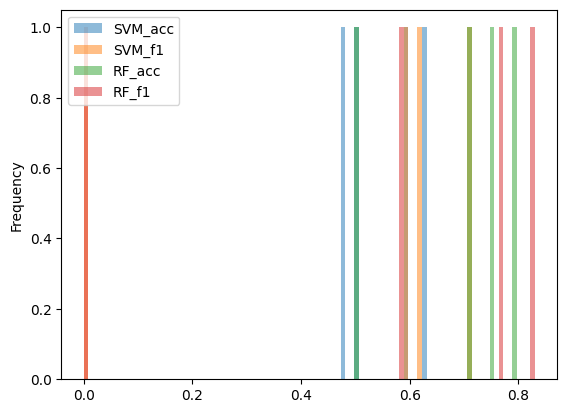

In [36]:
ax = results_all.plot.hist(bins=100, alpha=0.5)